Importamos las librerias necesarias.

In [241]:
#Librerias para Analisis exploratorio
import pandas as pd
import numpy as np

#Libreria para ver los dias feriados
import holidays

#Libreria para calcular distancia entre dos puntos.
from geopy.distance import geodesic

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime as dt


import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error, r2_score

Se carga el Dataset de los viajes de uber.

In [242]:
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [243]:
#Visualizamos el tipo de datos de cada columna y el tamano del df

df.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [244]:
#Convertimos las columnas object a un formato adecuado.
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  int64              
 1   date               200000 non-null  datetime64[ns]     
 2   fare_amount        200000 non-null  float64            
 3   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 4   pickup_longitude   200000 non-null  float64            
 5   pickup_latitude    200000 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    200000 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(5), int64(2)
memory usage: 13.7 MB


In [246]:
#Contamos los nulos para cada columna
nulos_por_columna = df.isnull().sum()

print(nulos_por_columna)


key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [247]:
#Eliminamos los nulos porque no son representativos
df = df.dropna()

In [248]:
#Verificamos que no haya nulos.

nulos_por_columna = df.isnull().sum()

print(nulos_por_columna)

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


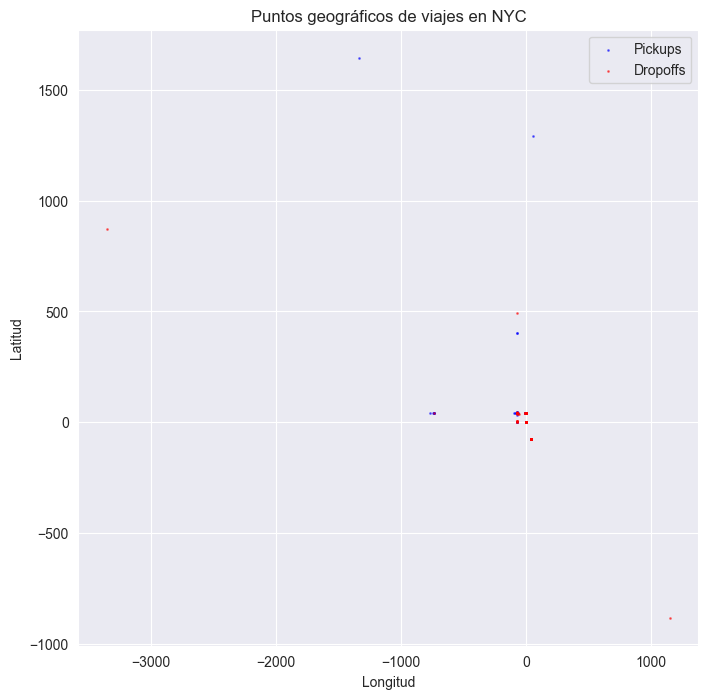

In [249]:
#Ploteamos la latitud y longitud para ver que puntos estan fuera de rango.
plt.figure(figsize=(8,8))
plt.scatter(
    df["pickup_longitude"], df["pickup_latitude"],
    c="blue", s=1, alpha=0.5, label="Pickups"
)
plt.scatter(
    df["dropoff_longitude"], df["dropoff_latitude"],
    c="red", s=1, alpha=0.5, label="Dropoffs"
)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.title("Puntos geográficos de viajes en NYC")
#Se limitan los ejes para poder ver en escala.
#plt.xlim(-70, -90)
#plt.ylim(40.5, 41.0)
plt.show()


In [250]:
# Utilizamos una funcion auxiliar para validad que la latitud y la longitud sean coordenadas que pertenecientes a la ciudad de new york, si no es así, reemplazamos por nulos para luego rellenarlos con el metodo de knn

def es_coord_ny(lat, lon):
    """
    Valida si una coordenada (lat, lon) está dentro de los límites de NYC mas
    un radio de 50 km para viajes por fuera de new york


    """
    return (40.5 <= lat <= 41.0) and (-74.3 <= lon <= -73.6)

df["pickup_en_ny"] = df.apply(lambda row: es_coord_ny(row["pickup_latitude"], row["pickup_longitude"]), axis=1)


df["dropoff_en_ny"] = df.apply(lambda row: es_coord_ny(row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)


df["viaje_en_ny"] = df["pickup_en_ny"] & df["dropoff_en_ny"]
df.describe()

,key,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999990e+05,199999,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,2.771248e+07,2012-03-22 14:58:56.889214720,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
min,1.000000e+00,2009-01-01 01:15:22.000000600,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382534e+07,2010-08-25 08:19:54,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774524e+07,2012-03-21 20:44:25,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155535e+07,2013-10-19 02:21:09.000000512,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,2015-06-30 23:40:39.000000100,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000
std,1.601386e+07,NaN,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995


In [251]:
#Vemos que 4121 coordenadas de pickup estan fuera de los limites de new york
df["pickup_en_ny"].value_counts()


pickup_en_ny
True     195878
False      4121
Name: count, dtype: int64

In [252]:
#Vemos que 4121 coordenadas de dropoff estan fuera de los limites de new york
df["dropoff_en_ny"].value_counts()


dropoff_en_ny
True     195879
False      4120
Name: count, dtype: int64

In [253]:
#Reemplamos las coordenadas fuera de zona por valores nulos con el objetivo de luego utilizar el metodo de knn para rellenarlos.
# Si pickup_en_ny es False → NaN en pickup_latitude y pickup_longitude
df.loc[~df["pickup_en_ny"], ["pickup_latitude", "pickup_longitude"]] = np.nan

# Si dropoff_en_ny es False → NaN en dropoff_latitude y dropoff_longitude
df.loc[~df["dropoff_en_ny"], ["dropoff_latitude", "dropoff_longitude"]] = np.nan


In [254]:
#Contamos los nulos nuevamente y verificamos que las coordenadas fuera de zona se encuentran nulas.
nulos_por_columna = df.isnull().sum()

print(nulos_por_columna)

key                     0
date                    0
fare_amount             0
pickup_datetime         0
pickup_longitude     4121
pickup_latitude      4121
dropoff_longitude    4120
dropoff_latitude     4120
passenger_count         0
pickup_en_ny            0
dropoff_en_ny           0
viaje_en_ny             0
dtype: int64


In [255]:
df.describe()

,key,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999990e+05,199999,199999.000000,195878.000000,195878.000000,195879.000000,195879.000000,199999.000000
mean,2.771248e+07,2012-03-22 14:58:56.889214720,11.359892,-73.975454,40.750782,-73.974514,40.751084,1.684543
min,1.000000e+00,2009-01-01 01:15:22.000000600,-52.000000,-74.299012,40.508697,-74.299833,40.510800,0.000000
25%,1.382534e+07,2010-08-25 08:19:54,6.000000,-73.992277,40.736457,-73.991597,40.735335,1.000000
50%,2.774524e+07,2012-03-21 20:44:25,8.500000,-73.982114,40.753298,-73.980545,40.753738,1.000000
75%,4.155535e+07,2013-10-19 02:21:09.000000512,12.500000,-73.968385,40.767521,-73.965426,40.768316,2.000000
max,5.542357e+07,2015-06-30 23:40:39.000000100,499.000000,-73.622390,40.991651,-73.600327,40.996788,208.000000
std,1.601386e+07,NaN,9.901760,0.034758,0.027063,0.034521,0.030858,1.385995


In [256]:
#Verificamos nuevamente el tamanio
df.shape

(199999, 12)

In [257]:
#Se crea df1 copia del df con las coordenadas validadas.
df1 = df.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                199999 non-null  int64              
 1   date               199999 non-null  datetime64[ns]     
 2   fare_amount        199999 non-null  float64            
 3   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 4   pickup_longitude   195878 non-null  float64            
 5   pickup_latitude    195878 non-null  float64            
 6   dropoff_longitude  195879 non-null  float64            
 7   dropoff_latitude   195879 non-null  float64            
 8   passenger_count    199999 non-null  int64              
 9   pickup_en_ny       199999 non-null  bool               
 10  dropoff_en_ny      199999 non-null  bool               
 11  viaje_en_ny        199999 non-null  bool               
dtypes: bool(3), datetime64[ns, UTC](1),

In [258]:
#Contamos los valores de los pasajeros
df1["passenger_count"].value_counts()


passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         708
208         1
Name: count, dtype: int64

In [259]:
#Investigando en internet averiguamos que existe UberFlash (para envio de paqueteria) y UberXL para viajes de grupos de hasta 6 personas.
#Por lo que el valor atipico en cantidad de pasajeros seria el de 208, que lo vamos a eliminar ya que solo aparece una vez


df1.loc[(df1['passenger_count'] > 6) , 'passenger_count'] = 6
df1["passenger_count"].value_counts()


passenger_count
1    138425
2     29428
5     14009
3      8881
4      4276
6      4272
0       708
Name: count, dtype: int64

In [260]:
#Se agrega una columna para extraer el dia de la semana en el que se hizo el viaje.Lunes= 0 y Domingo = 6
df1['date'] = pd.to_datetime(df1['date'])

df1['dia_de_la_semana'] = df1['date'].dt.weekday
df1['dia_de_la_semana'].value_counts()

dia_de_la_semana
4    30880
5    30251
3    30021
2    29037
1    28126
6    26441
0    25243
Name: count, dtype: int64

In [261]:
print(df1.columns)


Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_en_ny', 'dropoff_en_ny', 'viaje_en_ny',
       'dia_de_la_semana'],
      dtype='object')


In [262]:
#Se crea una columna para indicar la franja horaria donde ocurrio el viaje.

df1['pickup_datetime'] = df1['date'].dt.hour
df1
def franja(hora):
  if(0 <= hora <6):
    return 'Madrugada'
  elif(6<= hora <12):
    return 'Mañana'
  elif(12<= hora <18):
    return 'Tarde'
  elif(18<= hora <= 23):
    return 'Noche'

df1['franja_horaria'] = df1['pickup_datetime'].apply(franja)
df1['franja_horaria'].value_counts()

franja_horaria
Noche        68706
Tarde        57382
Mañana       48150
Madrugada    25761
Name: count, dtype: int64

In [263]:
df['date'].dt.year.unique()

array([2015, 2009, 2014, 2011, 2012, 2010, 2013], dtype=int32)

In [264]:
#Se utiliza la libreria Holidays para crear una columna que indique si el dia es feriado.

us_holidays = holidays.US(years=df1["date"].dt.year.unique())

df1["Feriado"] = df1["date"].dt.date.isin(us_holidays)
df1["Feriado"].value_counts()


Feriado
False    195475
True       4524
Name: count, dtype: int64

In [265]:
#Creamos una columna que determina en que semana del mes se produjo ese cambio.
def semana_del_mes(dt):
    dia = dt.day
    if 1 <= dia <= 7:
        return 1
    elif 8 <= dia <= 15:
        return 2
    elif 16 <= dia <= 23:
        return 3
    else:
        return 4

df1["week_of_month"] = df1["date"].apply(semana_del_mes)
df1["week_of_month"] .value_counts()


week_of_month
3    54171
2    53903
4    47156
1    44769
Name: count, dtype: int64

In [266]:

#Borro las columnas que no necesito para entrenar mi modelo

df1 = df1.drop(
    [
        'key', 'date', 'pickup_datetime',
        'passenger_count', 'pickup_en_ny', 'dropoff_en_ny', 'viaje_en_ny'
    ],
    axis=1
)

df1.columns


Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'dia_de_la_semana',
       'franja_horaria', 'Feriado', 'week_of_month'],
      dtype='object')

In [267]:
#Convertimos las columnas numéricas a categóricas
df1['franja_horaria'] = df1['franja_horaria'].astype('category')
df1['Feriado'] = df1['Feriado'].astype('category')
df1['dia_de_la_semana'] = df1['dia_de_la_semana'].astype('category')
df1['week_of_month'] = df1['week_of_month'].astype('category')

df1.isna().sum()


fare_amount             0
pickup_longitude     4121
pickup_latitude      4121
dropoff_longitude    4120
dropoff_latitude     4120
dia_de_la_semana        0
franja_horaria          0
Feriado                 0
week_of_month           0
dtype: int64

In [281]:
#One Hot Encoding

categorical_cols = ['franja_horaria', 'Feriado', 'dia_de_la_semana', 'week_of_month']

encoder = OneHotEncoder(sparse_output=False, drop=None)


encoded_array = encoder.fit_transform(df1[categorical_cols])


encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df1.index
)
df_encoded = pd.concat([df1.drop(columns=categorical_cols), encoded_df], axis=1)
df_encoded = df_encoded.drop(columns=['distance_km'], errors='ignore')


DIVIDO EN TRAIN Y TEST>
 Utilizo knn para rellenar valores faltantes.
 Escalo la distancia.
 Elimino las columnas de los puntos geograficos (debatir)


comentario: Primero reemplazo los valores faltantes en las coordenadas (las defini Nan por estar fuera de zona) y luego calculo la Distancia.

In [291]:
x_train, x_test, y_train, y_test = train_test_split(
    df_encoded.drop(columns='fare_amount'), df_encoded['fare_amount'], test_size=0.2, random_state=42)
x_train.isna().sum()

pickup_longitude            3303
pickup_latitude             3303
dropoff_longitude           3305
dropoff_latitude            3305
franja_horaria_Madrugada       0
franja_horaria_Mañana          0
franja_horaria_Noche           0
franja_horaria_Tarde           0
Feriado_0.0                    0
Feriado_1.0                    0
dia_de_la_semana_0             0
dia_de_la_semana_1             0
dia_de_la_semana_2             0
dia_de_la_semana_3             0
dia_de_la_semana_4             0
dia_de_la_semana_5             0
dia_de_la_semana_6             0
week_of_month_1                0
week_of_month_2                0
week_of_month_3                0
week_of_month_4                0
dtype: int64

In [292]:
cols_knn = [
    'pickup_longitude','pickup_latitude',
    'dropoff_longitude','dropoff_latitude'
]
cols_knn = [c for c in cols_knn if c in x_train.columns]  # solo las que existan

imputer = KNNImputer(n_neighbors=5, weights='distance')
x_train.loc[:, cols_knn] = imputer.fit_transform(x_train[cols_knn])
x_test.loc[:,  cols_knn] = imputer.transform(x_test[cols_knn])

In [293]:
x_train1 = x_train.copy(deep=True)
x_test1  = x_test.copy(deep=True)


In [294]:
#Ahora calculamos la distancia utilizando GEOPY
def calculate_distance(row):
    # Si falta alguna coordenada → devuelve NaN
    if (pd.isnull(row['pickup_latitude']) or
        pd.isnull(row['pickup_longitude']) or
        pd.isnull(row['dropoff_latitude']) or
        pd.isnull(row['dropoff_longitude'])):
        return np.nan

    start = (row['pickup_latitude'], row['pickup_longitude'])
    end = (row['dropoff_latitude'], row['dropoff_longitude'])

    return geodesic(start, end).kilometers

# Aplica la función
x_train1['distance_km'] = x_train1.apply(calculate_distance, axis=1)
x_test1['distance_km'] = x_test1.apply(calculate_distance, axis=1)


In [295]:
# 1) Drop de columnas geográficas
cols_drop = ['pickup_longitude','pickup_latitude',
             'dropoff_longitude','dropoff_latitude']

for X in (x_train1, x_test1):
    X.drop(columns=[c for c in cols_drop if c in X.columns], inplace=True)
#x_train.isna().sum()
x_test.isna().sum()

pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
franja_horaria_Madrugada    0
franja_horaria_Mañana       0
franja_horaria_Noche        0
franja_horaria_Tarde        0
Feriado_0.0                 0
Feriado_1.0                 0
dia_de_la_semana_0          0
dia_de_la_semana_1          0
dia_de_la_semana_2          0
dia_de_la_semana_3          0
dia_de_la_semana_4          0
dia_de_la_semana_5          0
dia_de_la_semana_6          0
week_of_month_1             0
week_of_month_2             0
week_of_month_3             0
week_of_month_4             0
dtype: int64

In [309]:
#Escalo la distancia
scaler_dist = StandardScaler()
x_train1['distance_km'] = scaler_dist.fit_transform(x_train1[['distance_km']])
x_test1['distance_km'] = scaler_dist.transform(x_test1[['distance_km']])

x_test1.isna().sum()


franja_horaria_Madrugada    0
franja_horaria_Mañana       0
franja_horaria_Noche        0
franja_horaria_Tarde        0
Feriado_0.0                 0
Feriado_1.0                 0
dia_de_la_semana_0          0
dia_de_la_semana_1          0
dia_de_la_semana_2          0
dia_de_la_semana_3          0
dia_de_la_semana_4          0
dia_de_la_semana_5          0
dia_de_la_semana_6          0
week_of_month_1             0
week_of_month_2             0
week_of_month_3             0
week_of_month_4             0
distance_km                 0
dtype: int64

In [310]:
lr = LinearRegression()
lr.fit(x_train1, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [303]:
y_pred = lr.predict(x_test1)

In [311]:
lr.coef_, lr.intercept_

(array([-0.61013242,  0.20171269, -0.25086577,  0.6592855 ,  0.2687161 ,
        -0.2687161 , -0.15290337, -0.07623445,  0.17546641,  0.26019302,
         0.20722463, -0.21610456, -0.19764166, -0.00956605, -0.03193416,
         0.02236212,  0.01913809,  8.16401002]),
 np.float64(11.016115723593229))

In [312]:
lr.score(x_train1,y_train), lr.score(x_test1,y_test)

(0.688137047518642, 0.6289131208686822)